In [37]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import layers

# 시드 고정
SEED = 430
keras.utils.set_random_seed(SEED)

"""
## 데이터가 바뀌었을 때 손 봐줘야할 부분
"""

NUM_CLASSES = 6
INPUT_SHAPE = (200, 200, 3)

x_train, x_test, y_train, y_test = np.load("/content/drive/MyDrive/steel_surface_200.npy", allow_pickle=True)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")


x_train shape: (1080, 200, 200, 3) - y_train shape: (1080,)
x_test shape: (360, 200, 200, 3) - y_test shape: (360,)


In [41]:
#하이퍼 파라미터 튜닝

# DATA
BUFFER_SIZE = 256 #원래 512
BATCH_SIZE = 64 #원래 256

# AUGMENTATION
IMAGE_SIZE = 200
PATCH_SIZE = 10
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 200 #원래 100

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

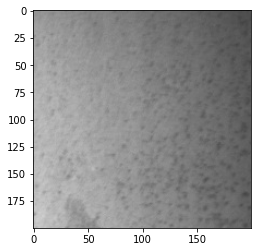

In [42]:
#데이터 증강기법

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


#SPT
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)


# 패치 시각화
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image)
plt.show()
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
)

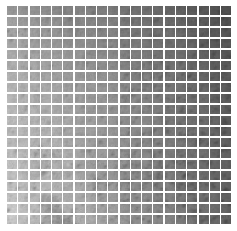

ORIGINAL


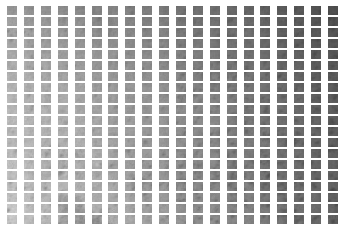

LEFT-UP


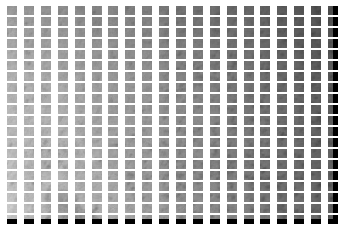

LEFT-DOWN


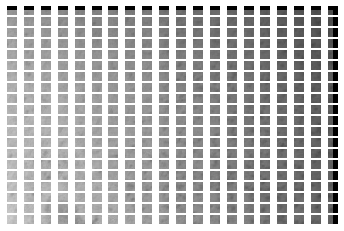

RIGHT-UP


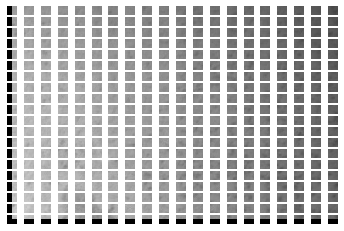

RIGHT-DOWN


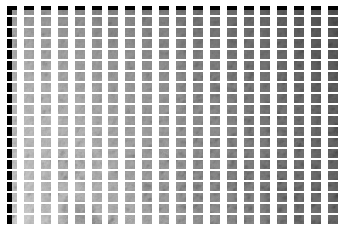

In [43]:
(token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image/255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
for row in range(n):
    for col in range(n):
        plt.subplot(n, n, count)
        count = count + 1
        image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 3))
        plt.imshow(image)
        plt.axis("off")
plt.show()

(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image/255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    # plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 5 * 3))
            plt.imshow(image[..., 3 * index : 3 * index + 3])
            plt.axis("off")
    plt.show()

In [44]:
#패치 인코딩
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches


class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores


# MLP
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

# ViT 모델 생성
def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


"""
## Compile, train, and evaluate the mode
"""

# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


def run_experiment(model):
    total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
    )
    model.save_weights('/content/drive/MyDrive/model_weights_steel_surface')
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    return history


# Run experiments with the vanilla ViT

vit = create_vit_classifier(vanilla=True)
history = run_experiment(vit)

# Run experiments with the Shifted Patch Tokenization and
# Locality Self Attention modified ViT

vit_sl = create_vit_classifier(vanilla=False)
history = run_experiment(vit_sl)


Epoch 1/200
16/16 [==============================] - 17s 496ms/step - loss: 11.9582 - accuracy: 0.2891 - top-5-accuracy: 0.8920 - val_loss: 6.1902 - val_accuracy: 0.3333 - val_top-5-accuracy: 0.8889
Epoch 2/200
16/16 [==============================] - 7s 425ms/step - loss: 4.7442 - accuracy: 0.4002 - top-5-accuracy: 0.9434 - val_loss: 2.7155 - val_accuracy: 0.3981 - val_top-5-accuracy: 0.9722
Epoch 3/200
16/16 [==============================] - 7s 423ms/step - loss: 3.4729 - accuracy: 0.4249 - top-5-accuracy: 0.9619 - val_loss: 1.1800 - val_accuracy: 0.5926 - val_top-5-accuracy: 0.9907
Epoch 4/200
16/16 [==============================] - 7s 426ms/step - loss: 1.9986 - accuracy: 0.5267 - top-5-accuracy: 0.9825 - val_loss: 1.0935 - val_accuracy: 0.6019 - val_top-5-accuracy: 1.0000
Epoch 5/200
16/16 [==============================] - 7s 429ms/step - loss: 1.6895 - accuracy: 0.5669 - top-5-accuracy: 0.9877 - val_loss: 0.9857 - val_accuracy: 0.6944 - val_top-5-accuracy: 1.0000
Epoch 6/200
1

'\n# Final Notes\n\nWith the help of Shifted Patch Tokenization and Locality Self Attention,\nwe were able to get ~**3-4%** top-1 accuracy gains on CIFAR100.\n\nThe ideas on Shifted Patch Tokenization and Locality Self Attention\nare very intuitive and easy to implement. The authors also ablates of\ndifferent shifting strategies for Shifted Patch Tokenization in the\nsupplementary of the paper.\n\nI would like to thank [Jarvislabs.ai](https://jarvislabs.ai/) for\ngenerously helping with GPU credits.\n'

In [45]:
#Test set(vanilla true)정확도
y_pred_test=vit.predict(x_test)
print(y_pred_test, type(y_pred_test), y_pred_test.shape)
y_pred=[]
for ar in y_pred_test:
  y_pred.append(np.argmax(ar))
y_pred = np.array(y_pred)
print(y_pred, y_pred.shape)
print(y_test, y_test.shape)

[[ 9.69191432e-01 -1.52727518e+01  3.06093063e+01  6.07128859e-01
  -8.35748482e+00 -6.53239346e+00]
 [-2.58629823e+00  3.21204400e+00 -4.59448433e+00  5.18793297e+00
  -2.60630774e+00 -3.65012079e-01]
 [-1.09969158e+01  2.06497459e+01 -1.21389513e+01  3.32157278e+00
  -3.70439315e+00  6.22317123e+00]
 ...
 [ 1.57960892e+00 -6.19087744e+00  1.14841003e+01  2.39925757e-02
  -2.60500050e+00 -1.27600813e+00]
 [-6.26125097e-01 -2.49056664e+01  4.58679771e+01 -4.37743521e+00
  -1.13451805e+01 -6.07501316e+00]
 [-3.13167143e+00  3.34663820e+00 -5.14503527e+00  6.47058678e+00
  -3.07085943e+00 -1.20233274e+00]] <class 'numpy.ndarray'> (360, 6)
[2 3 1 2 3 1 2 4 3 2 4 0 1 2 4 2 2 2 0 3 3 4 0 5 2 4 4 4 1 5 5 3 0 0 5 0 3
 1 2 2 0 3 2 1 0 4 1 0 5 0 2 1 1 4 1 4 4 3 1 2 1 2 0 1 5 0 2 2 3 5 3 3 4 1
 5 4 1 4 2 2 2 2 0 4 5 0 5 4 4 4 3 4 5 0 4 0 2 2 3 4 0 1 1 3 0 0 5 3 0 0 2
 1 5 2 4 3 0 4 3 0 3 5 4 0 0 4 1 0 0 0 2 4 2 3 1 2 0 5 2 5 5 0 0 2 4 1 5 2
 1 4 2 0 4 0 1 5 3 4 3 5 0 3 1 1 4 2 4 5 0 5 5 2 3 0 0 

In [46]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
print("accuracy:",accuracy_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred, average='weighted'))
print("Recall:",recall_score(y_test, y_pred, average='weighted'))
print("F1-Score:",f1_score(y_test, y_pred, average='weighted'))

accuracy: 0.975
Precision: 0.9757498932143226
Recall: 0.975
F1-Score: 0.975016547310729


In [47]:
#Test set(vanilla False)정확도
y_pred_test_f=vit_sl.predict(x_test)
print(y_pred_test_f, type(y_pred_test_f), y_pred_test_f.shape)
y_pred_f=[]
for ar in y_pred_test_f:
  y_pred_f.append(np.argmax(ar))
y_pred_f = np.array(y_pred_f)
print(y_pred_f, y_pred_f.shape)
print(y_test, y_test.shape)

[[-1.4017566e+00 -8.0207598e-01  1.9993008e+00  9.4870979e-01
  -2.1489120e+00  1.2072473e+00]
 [-5.1554198e+00  7.1593652e+00 -1.3508019e+01  3.3045959e+01
  -2.2670347e+01 -2.8292198e-02]
 [-6.8652983e+00  5.1225929e+01 -1.9618961e+01  1.8744811e+00
  -2.6973236e+01 -2.8360095e+00]
 ...
 [-2.5459909e+00 -1.0120103e+01  1.5050011e+01 -3.9765489e+00
  -2.2951281e+00 -1.9844782e+00]
 [-6.5931664e+00 -8.1842661e+00  1.5799766e+01 -3.7478814e+00
  -4.6243267e+00  4.9597976e-01]
 [-5.9398694e+00  6.8491030e+00 -1.3836552e+01  3.5112900e+01
  -2.3632017e+01 -1.0471766e+00]] <class 'numpy.ndarray'> (360, 6)
[2 3 1 2 3 1 2 4 3 2 4 0 1 2 4 2 2 3 0 3 3 4 0 5 2 4 4 4 1 5 5 3 0 0 5 0 3
 1 1 2 0 3 2 1 0 4 1 0 5 0 2 1 1 4 4 4 4 3 1 2 1 2 0 1 5 0 2 2 3 5 3 3 4 1
 5 4 1 4 2 2 0 2 0 4 5 0 5 4 4 4 3 4 5 0 4 0 2 2 3 4 0 1 1 3 0 0 5 3 0 0 2
 1 5 2 4 3 0 4 3 0 3 5 4 0 0 4 1 0 0 0 2 4 3 3 1 2 0 5 2 5 5 0 0 2 4 1 5 2
 1 4 2 0 4 0 1 5 3 4 3 5 0 3 1 1 4 2 4 3 0 5 1 2 3 0 0 3 0 1 4 1 5 5 2 2 4
 0 0 1 3 5 5 4 5

In [48]:
print("accuracy:",accuracy_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred, average='weighted'))
print("Recall:",recall_score(y_test, y_pred, average='weighted'))
print("F1-Score:",f1_score(y_test, y_pred, average='weighted'))

accuracy: 0.975
Precision: 0.9757498932143226
Recall: 0.975
F1-Score: 0.975016547310729
